In [2]:
import numpy as np
import GPy
import torch
import botorch
from known_bound.acquisition_function import EI_acquisition_opt,SLogTEI_acquisition_opt,SLogEI_acquisition_opt
from known_bound.utlis import  get_initial_points,transform,opt_model_MLE,opt_model_MAP
from known_bound.SLogGP import SLogGP

from botorch.test_functions import Branin
from botorch.utils.transforms import unnormalize,normalize


import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger('lengthscale').disabled = True
logging.getLogger('variance').disabled = True
logging.getLogger('psi').disabled = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

function_information = []

temp={}
temp['name']='Branin2D' 
temp['function'] = Branin(negate=False)
temp['fstar'] =  0.397887 
function_information.append(temp)

# GP+EI

In [3]:
for information in function_information:

    fun = information['function']
    dim = fun.dim
    bounds = fun.bounds
    standard_bounds=np.array([0.,1.]*dim).reshape(-1,2)
    
    n_init = 4*dim
    N = 10
    fstar = information['fstar']
    
    step_size = 3
    iter_num = 50
        
    lengthscale_range = [0.001,2]
    variance_range = [0.001**2,20]
    
    print(information['name'])
    
    
    ############################# GP+EI ###################################
    BO_EI = []

    for exp in range(N):
        
        noise = 6e-6
        
        print(exp)
        seed = exp

        X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
        Y_BO = torch.tensor(
            [fun(x) for x in X_BO], dtype=dtype, device=device
        ).reshape(-1,1)

        best_record = [Y_BO.min().item()]
        np.random.seed(1234)

        for i in range(iter_num):
                
                if i%step_size == 0:
                    Y_mean =  Y_BO.mean()
                    Y_std = Y_BO.std()
            
                train_Y = (Y_BO -Y_mean) / Y_std
                train_X = normalize(X_BO, bounds)
                
                
                minimal = train_Y.min().item()
                
                train_Y = train_Y.numpy()
                train_X = train_X.numpy()
                
                # train the GP
                if i%step_size == 0:
                    
                    parameters = opt_model_MLE(train_X,train_Y,dim,'GP',noise=noise,seed=i,lengthscale_range=lengthscale_range,variance_range=variance_range)
                        
                    lengthscale = parameters[0]
                    variance = parameters[1]
                    
                kernel = GPy.kern.RBF(input_dim=dim,lengthscale=lengthscale,variance=variance)
                m = GPy.models.GPRegression(train_X.reshape(-1,dim), train_Y.reshape(-1,1),kernel)
                m.Gaussian_noise.fix(noise)

                np.random.seed(i)
                standard_next_X = EI_acquisition_opt(m,bounds=standard_bounds,f_best=minimal)
                X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
                Y_next = fun(X_next).reshape(-1,1)

                # Append data
                X_BO = torch.cat((X_BO, X_next), dim=0)
                Y_BO = torch.cat((Y_BO, Y_next), dim=0)
                
                best_record.append(Y_BO.min().item())
                
                noise = variance*10**(-5)   #adaptive noise
                noise = np.round(noise, -int(np.floor(np.log10(noise))))
                noise = max(noise,10**(-7))
                
        best_record = np.array(best_record) 
        BO_EI.append(best_record)

Branin2D
0
1
2
3
4
5
6
7
8
9


# BABO

In [4]:
for information in function_information:

    fun = information['function']
    dim = fun.dim
    bounds = fun.bounds
    standard_bounds=np.array([0.,1.]*dim).reshape(-1,2)
    
    n_init = 4*dim
    N = 10
    fstar = information['fstar']
    
    step_size = 3
    iter_num = 50
        
    lengthscale_range = [0.001,2]
    variance_range = [0.001**2,20]
    
    print(information['name'])
    
   
 ######################## BABO #######################################

    BABO = []

    for exp in range(N):
        
        noise = 6e-6
    
        seed = exp
    
        print(exp)

        X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    
    
        Y_BO = torch.tensor(
            [fun(x) for x in X_BO], dtype=dtype, device=device
        ).reshape(-1,1)

        best_record = [Y_BO.min().item()]
        np.random.seed(1234)
    
        tolerance_level = 2.5
        uncertainty = 1
    
        boundarys = []
        variances = []

        Train = False

        for i in range(iter_num):
        
                train_Y = Y_BO.numpy()
            
                if i%step_size == 0 or Train:
                    Y_min = np.min(train_Y)
                    Y_std = np.std(train_Y-Y_min)
                
                fstar_shifted = fstar -Y_min # shifted lower bound
                train_Y = train_Y - Y_min  # shift Y
            
                #scalise Y_shift and fstar_shift
                train_Y = train_Y/Y_std
                fstar_shifted = fstar_shifted/Y_std

                train_X = normalize(X_BO, bounds)
                train_X = train_X.numpy()
            
                lower = -np.min(train_Y)+10**(-6)
                if Y_std<=2.0:
                    upper = -fstar_shifted+300/Y_std 
                else:
                    upper = -fstar_shifted+30

                c_range = [lower,upper]
            
                mu_prior = np.log(-fstar_shifted)
                sigma_prior = np.sqrt(2*(np.log(-fstar_shifted+0.1/Y_std)-mu_prior)) * uncertainty
                prior_parameter = [mu_prior,sigma_prior]
            

                if i%step_size == 0 or Train:
                
                    if sigma_prior<7.5:
                                
                        parameters = opt_model_MAP(train_X,train_Y,dim,lengthscale_range,variance_range,c_range,
                                                        prior_parameter,noise=noise,seed=i)

                        c = parameters[2]
                        MAP = True
                    
                        if abs(np.log(c) - mu_prior)>tolerance_level*sigma_prior :
                                                                
                            temp = (abs(np.log(c) - mu_prior))/ sigma_prior 
                            uncertainty *= temp 
                        
                            MAP = False
                            parameters = opt_model_MLE(train_X,train_Y,dim,'SLogGP',noise=noise,seed=i,
                                                        lengthscale_range=lengthscale_range,
                                                        variance_range=variance_range,c_range=c_range)  
                        
                        if MAP:    
                            if parameters[1]<0.25**2: 
                                    
                                    parameters = opt_model_MLE(train_X,train_Y,dim,'SLogGP',noise=noise,seed=i,
                                            lengthscale_range=lengthscale_range,
                                            variance_range=variance_range,c_range=c_range)
                                            
                    else:
                        parameters = opt_model_MLE(train_X,train_Y,dim,'SLogGP',noise=noise,seed=i,
                                                            lengthscale_range=lengthscale_range,
                                                            variance_range=variance_range,c_range=c_range)
                
                           
                lengthscale = parameters[0]
                variance = parameters[1]
                c = parameters[2]
                
                
                warp_Y = np.log(train_Y+c)
                mean_warp_Y = np.mean(warp_Y) # use to predict mean
                warp_Y_standard = warp_Y-mean_warp_Y
            
            
                kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  
                m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
                m.Gaussian_noise.variance.fix(noise)
            
                np.random.seed(i)
                if -c>=fstar_shifted:
                    standard_next_X = SLogEI_acquisition_opt(model=m,bounds=standard_bounds,
                                                                f_best=np.min(train_Y),
                                                                c=c,f_mean=mean_warp_Y)
                else:
                    standard_next_X = SLogTEI_acquisition_opt(model=m,bounds=standard_bounds,
                                                                f_best=np.min(train_Y),c=c,
                                                                f_mean=mean_warp_Y,fstar=fstar_shifted)  
                
                X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
                Y_next = fun(X_next).reshape(-1,1)      

                # Append data
                X_BO = torch.cat((X_BO, X_next), dim=0)
                Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
                best_record.append(Y_BO.min().item())
                
            
                noise = variance*10**(-5)   #adaptive noise
                noise = np.round(noise, -int(np.floor(np.log10(noise))))
                noise = max(noise,10**(-7))  


                if Y_BO.min().item()<=-c*Y_std+Y_min:
                     Train = True
                else:
                     Train = False

            
        best_record = np.array(best_record)    
        BABO.append(best_record)

Branin2D
0
1
2
3
4
5
6
7
8
9


# Plot

In [5]:
import matplotlib.pyplot as plt

def log_RegretMean_plot(res,fstar,label,color,linestyle,error_bound=True):
    
    
    total_record = (np.array(res)-fstar)
    
    N = total_record.shape[0]
    
    std = np.std(total_record,axis=0)
    
    mean = np.mean(total_record,axis=0)
    
    iter = np.array(range(mean.shape[0]))
    
    lower = mean - 1*std/np.sqrt(N)
    upper = mean + 1*std/np.sqrt(N)
    
    lower.astype(float)
    upper.astype(float)
    
    
    plt.plot(mean,linewidth=2,label=label,color=color,linestyle=linestyle)
    if error_bound:
        plt.fill_between(iter, lower, upper,alpha=0.25,color=color)
    
    plt.yscale("log")  

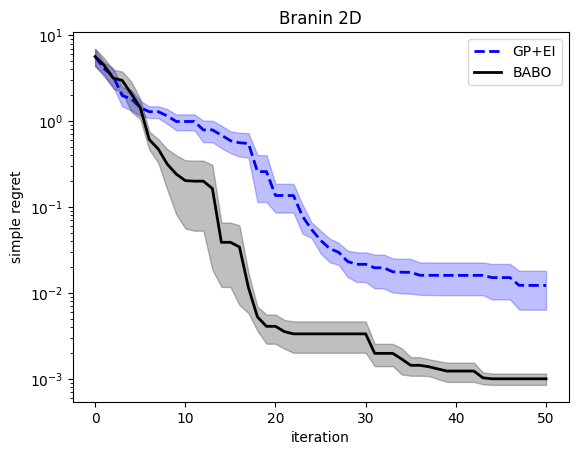

In [6]:
log_RegretMean_plot(BO_EI,fstar=fstar,label='GP+EI',color='blue',linestyle='dashed',error_bound=True)
log_RegretMean_plot(BABO,fstar=fstar,label='BABO',color='black',linestyle='-',error_bound=True)

plt.title('Branin 2D')

plt.xlabel('iteration')
plt.ylabel('simple regret')
plt.legend()